In [1]:
import os, sys

# Ruta raíz del proyecto (carpeta madly_safe)
root_path = os.path.abspath("..")
print("Project root:", root_path)

if root_path not in sys.path:
    sys.path.append(root_path)


Project root: C:\Users\cscpd\madly_safe


In [2]:
from src.etl import cargar_y_preparar_2025

df_proc, df_target = cargar_y_preparar_2025()
df_proc.shape, df_target.shape


((32327, 25), (18136, 25))

In [3]:
df_target.columns


Index(['num_expediente', 'fecha', 'hora', 'localizacion', 'numero',
       'cod_distrito', 'distrito', 'tipo_accidente', 'estado_meteorológico',
       'tipo_vehiculo', 'tipo_persona', 'rango_edad', 'sexo', 'cod_lesividad',
       'lesividad', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_alcohol',
       'positiva_droga', 'hora_num', 'dia_semana_num', 'dia_semana',
       'es_fin_semana', 'franja_horaria', 'grave'],
      dtype='object')

In [4]:
import numpy as np
import pandas as pd

# Ajusta este nombre si en tus columnas aparece de otra forma
col_meteo = "estado_meteorológico"  # si da error, revisa df_target.columns

cols_modelo = [
    "tipo_persona",
    "tipo_vehiculo",
    "rango_edad",
    "sexo",
    "distrito",
    "dia_semana",
    "franja_horaria",
    col_meteo,
]

X = df_target[cols_modelo].copy()
y = df_target["grave"].astype(int)

X.head(), y.value_counts()


(   tipo_persona            tipo_vehiculo       rango_edad    sexo   distrito  \
 0     Conductor               Ciclomotor  De 30 a 34 años  Hombre  CHAMARTÍN   
 1     Conductor                  Turismo  De 40 a 44 años  Hombre  CHAMARTÍN   
 2      Pasajero                  Turismo  De 40 a 44 años   Mujer  CHAMARTÍN   
 5     Conductor                  Turismo  De 18 a 20 años  Hombre     LATINA   
 10    Conductor  Motocicleta hasta 125cc  De 30 a 34 años  Hombre     CENTRO   
 
    dia_semana   franja_horaria estado_meteorológico  
 0   Miércoles  Noche_madrugada            Despejado  
 1   Miércoles  Noche_madrugada            Despejado  
 2   Miércoles  Noche_madrugada            Despejado  
 5   Miércoles  Noche_madrugada            Despejado  
 10  Miércoles     Manana_punta            Despejado  ,
 grave
 0    17832
 1      304
 Name: count, dtype: int64)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((14508, 8), (3628, 8), 0.016749379652605458, 0.01681367144432194)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, f1_score, roc_auc_score

cat_features = cols_modelo

# Usamos OneHotEncoder con sparse=False para que valga también para HistGradientBoosting
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_features),
    ]
)

def entrenar_y_evaluar(nombre, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {nombre} ===")
    print(classification_report(y_test, y_pred))
    print("F1 macro:", f1)
    print("ROC-AUC :", roc)

    return modelo, f1, roc


In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
)

modelo_logreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", logreg),
])

modelo_logreg, f1_logreg, roc_logreg = entrenar_y_evaluar(
    "Regresión Logística (baseline)",
    modelo_logreg,
    X_train, y_train, X_test, y_test
)


C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



=== Regresión Logística (baseline) ===
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3567
           1       0.06      0.80      0.12        61

    accuracy                           0.79      3628
   macro avg       0.53      0.80      0.50      3628
weighted avg       0.98      0.79      0.87      3628

F1 macro: 0.4989520853611503
ROC-AUC : 0.8623562069425104


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

modelo_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", rf),
])

modelo_rf, f1_rf, roc_rf = entrenar_y_evaluar(
    "Random Forest",
    modelo_rf,
    X_train, y_train, X_test, y_test
)


C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3567
           1       0.00      0.00      0.00        61

    accuracy                           0.97      3628
   macro avg       0.49      0.49      0.49      3628
weighted avg       0.97      0.97      0.97      3628

F1 macro: 0.492516435865156
ROC-AUC : 0.8499795484105208


In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=None,
    max_iter=400,
    random_state=42,
)

modelo_hgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", hgb),
])

modelo_hgb, f1_hgb, roc_hgb = entrenar_y_evaluar(
    "HistGradientBoosting",
    modelo_hgb,
    X_train, y_train, X_test, y_test
)


C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



=== HistGradientBoosting ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3567
           1       0.00      0.00      0.00        61

    accuracy                           0.98      3628
   macro avg       0.49      0.50      0.50      3628
weighted avg       0.97      0.98      0.97      3628

F1 macro: 0.49576094510076446
ROC-AUC : 0.8361276179183499


C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cscpd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import pandas as pd

resumen = pd.DataFrame({
    "modelo": ["logreg", "rf", "hgb"],
    "F1_macro": [f1_logreg, f1_rf, f1_hgb],
    "ROC_AUC": [roc_logreg, roc_rf, roc_hgb],
})
resumen


,modelo,F1_macro,ROC_AUC
0,logreg,0.498952,0.862356
1,rf,0.492516,0.849980
2,hgb,0.495761,0.836128


In [11]:
# Elegimos explícitamente la REGRESIÓN LOGÍSTICA como modelo final

modelo_final = modelo_logreg
nombre_modelo_final = "Regresión Logística (balanced)"

print("Modelo final elegido:", nombre_modelo_final)


Modelo final elegido: Regresión Logística (balanced)


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones y probabilidades del modelo final (logística)
y_pred = modelo_final.predict(X_test)
y_proba = modelo_final.predict_proba(X_test)[:, 1]

print("=== Informe de clasificación (Regresión Logística) ===")
print(classification_report(y_test, y_pred))

f1_macro = f1_score(y_test, y_pred, average="macro")
roc_auc = roc_auc_score(y_test, y_proba)

print("F1 macro:", f1_macro)
print("ROC-AUC :", roc_auc)


=== Informe de clasificación (Regresión Logística) ===
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3567
           1       0.06      0.80      0.12        61

    accuracy                           0.79      3628
   macro avg       0.53      0.80      0.50      3628
weighted avg       0.98      0.79      0.87      3628

F1 macro: 0.4989520853611503
ROC-AUC : 0.8623562069425104


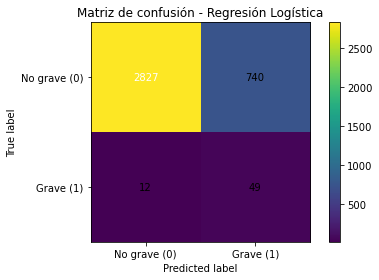

In [13]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
classes = ["No grave (0)", "Grave (1)"]

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes,
    yticklabels=classes,
    ylabel="True label",
    xlabel="Predicted label",
    title="Matriz de confusión - Regresión Logística",
)

# Escribimos los números dentro de cada celda
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.show()


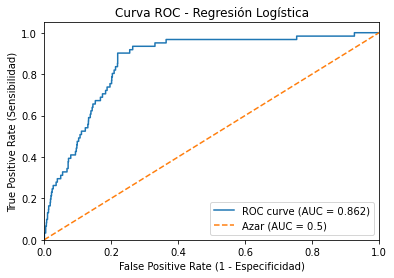

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc_plot = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_plot:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", label="Azar (AUC = 0.5)")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (1 - Especificidad)")
ax.set_ylabel("True Positive Rate (Sensibilidad)")
ax.set_title("Curva ROC - Regresión Logística")
ax.legend(loc="lower right")
plt.show()


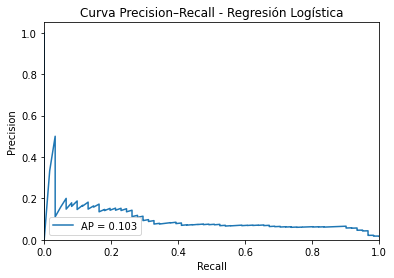

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

fig, ax = plt.subplots()
ax.plot(recall, precision, label=f"AP = {ap:.3f}")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Curva Precision–Recall - Regresión Logística")
ax.legend(loc="lower left")
plt.show()


In [16]:
# Extraer nombres de variables y coeficientes de la regresión logística

# 1. Obtenemos el OneHotEncoder ya entrenado
preprocess = modelo_final.named_steps["preprocess"]
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]

feature_names_ohe = ohe.get_feature_names_out(cols_modelo)

# 2. Coeficientes de la regresión (para clase positiva)
clf = modelo_final.named_steps["clf"]
coefs = clf.coef_.ravel()  # shape (n_features,)

# 3. Construimos un DataFrame ordenado por importancia (valor absoluto)
import pandas as pd
coef_df = pd.DataFrame({
    "feature": feature_names_ohe,
    "coef": coefs,
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

coef_df_sorted.head(20)


,feature,coef,abs_coef
20,tipo_vehiculo_Motocicleta > 125cc,3.305030,3.305030
2,tipo_persona_Peatón,2.627311,2.627311
31,tipo_vehiculo_VMU eléctrico,2.221103,2.221103
21,tipo_vehiculo_Motocicleta hasta 125cc,2.166037,2.166037
26,tipo_vehiculo_Sin especificar,-1.755305,1.755305
8,tipo_vehiculo_Bicicleta,1.724623,1.724623
28,tipo_vehiculo_Tractocamión,-1.690034,1.690034
13,tipo_vehiculo_Ciclomotor,1.617779,1.617779
0,tipo_persona_Conductor,-1.488000,1.488000
47,rango_edad_De 70 a 74 años,-1.469926,1.469926


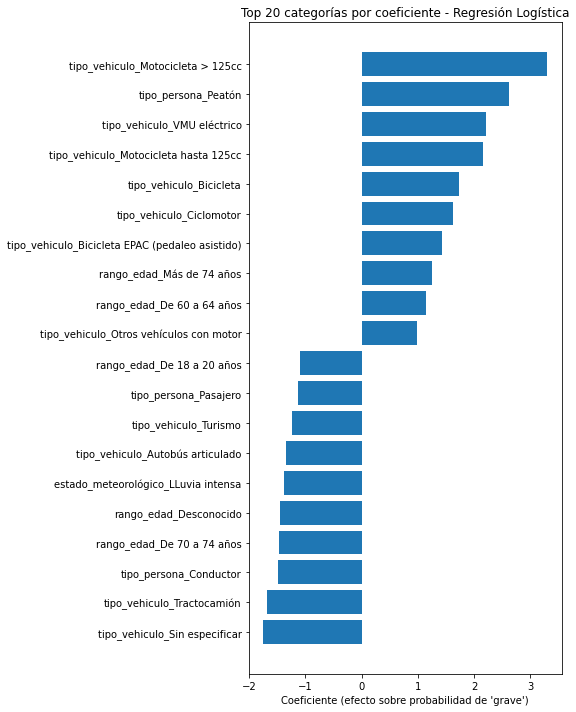

In [17]:
top_n = 20
top_coef = coef_df_sorted.head(top_n).sort_values("coef")

fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(top_coef["feature"], top_coef["coef"])
ax.set_xlabel("Coeficiente (efecto sobre probabilidad de 'grave')")
ax.set_title(f"Top {top_n} categorías por coeficiente - Regresión Logística")
plt.tight_layout()
plt.show()


In [18]:
import pathlib
import joblib

ruta_modelo_mejor = pathlib.Path("..") / "models" / "modelo_mejor_2025.joblib"
joblib.dump(modelo_final, ruta_modelo_mejor)

ruta_modelo_mejor, ruta_modelo_mejor.exists()


(WindowsPath('../models/modelo_mejor_2025.joblib'), True)